# Test de l'API et Interface Streamlit

Ce notebook documente le déploiement de l'API de prédiction de sentiments et l'interface Streamlit développée pour Air Paradis.

## Architecture technique

**Backend API**
- Framework : FastAPI
- Serveur : Uvicorn
- Déploiement : Heroku

**Frontend**
- Framework : Streamlit
- Déploiement : Streamlit Cloud

**Endpoints disponibles**

| Endpoint | Méthode | Description |
|----------|---------|-------------|
| `/` | GET | Informations de l'API |
| `/health` | GET | Health check |
| `/predict` | POST | Prédire un tweet |
| `/predict/batch` | POST | Prédire plusieurs tweets |
| `/docs` | GET | Documentation Swagger |

In [1]:
# Import des bibliothèques
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Bibliothèques importées")

✓ Bibliothèques importées


### Code de l'API

Extrait du fichier `api/app.py` :

In [2]:
# Visualisation du code de l'API (lecture du fichier)
with open('../api/app.py', 'r') as f:
    api_code = f.read()

print("="*80)
print("CODE DE L'API FLASK (api/app.py)")
print("="*80)
print(api_code[:2000])  # Afficher les premiers 2000 caractères
print("\n[... code complet dans api/app.py ...]")
print("="*80)

CODE DE L'API FLASK (api/app.py)
"""
API FastAPI pour la prédiction de sentiments de tweets - Air Paradis

Cette API permet de prédire le sentiment (positif/négatif) de tweets pour détecter
le bad buzz en temps réel.

Endpoints:
    - GET /: Page d'accueil avec informations API
    - GET /health: Health check
    - POST /predict: Prédiction de sentiment
    - POST /predict/batch: Prédiction batch
    - GET /models: Liste des modèles disponibles
"""

from fastapi import FastAPI, HTTPException, status
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel, Field, validator
from typing import List, Optional, Dict
import logging
from datetime import datetime
import os
import joblib
import numpy as np

# Imports conditionnels pour les modèles lourds (uniquement si nécessaire)
try:
    import tensorflow as tf
    from transformers import BertTokenizer, TFBertForSequenceClassification
    TF_AVAILABLE = True
except ImportError:
    TF_AVAILABLE = False
    logger = 

## Tests de l'API

On configure l'URL de l'API déployée :

In [3]:
# Configuration de l'URL de l'API
# Modifier selon l'environnement (local, Azure, Heroku)
API_URL = "http://localhost:8000"  # API locale
# API_URL = "https://airparadis-sentiment-api.azurewebsites.net"  # Azure
# API_URL = "https://airparadis-sentiment.herokuapp.com"  # Heroku

print(f"API URL configurée : {API_URL}")

API URL configurée : http://localhost:8000


### Test du health check

In [4]:
# Test du endpoint racine
try:
    response = requests.get(f"{API_URL}/")
    print("Status Code:", response.status_code)
    print("Response:", response.json())
    print("\n✅ API opérationnelle !")
except Exception as e:
    print(f"❌ Erreur : {e}")
    print("\nAssurez-vous que l'API est démarrée :")
    print("  cd api && python app.py")

Status Code: 200
Response: {'message': 'Air Paradis - Sentiment Analysis API', 'version': '1.0.0', 'description': 'API de prédiction de sentiments pour la détection de bad buzz', 'endpoints': {'health': '/health', 'predict': '/predict (POST)', 'predict_batch': '/predict/batch (POST)', 'models': '/models (GET)', 'documentation': '/docs'}, 'model_type': 'logistic', 'timestamp': '2026-01-18T22:18:46.473753'}

✅ API opérationnelle !


### Test avec un tweet positif

In [5]:
# Test de prédiction avec un tweet positif
tweet_positif = "I love flying with this airline! Great service and comfortable seats!"

response = requests.post(
    f"{API_URL}/predict",
    json={"text": tweet_positif}
)

result = response.json()
print("="*80)
print("TEST : Tweet Positif")
print("="*80)
print(f"Tweet : {tweet_positif}")
print(f"\nRésultat :")
print(f"  Sentiment : {result['sentiment_label'].upper()}")
print(f"  Confiance : {result['confidence']:.2%}")
print(f"  Probabilités : Positif={result['probabilities']['positive']:.2%}, Négatif={result['probabilities']['negative']:.2%}")
print("="*80)

TEST : Tweet Positif
Tweet : I love flying with this airline! Great service and comfortable seats!

Résultat :
  Sentiment : POSITIF
  Confiance : 85.91%
  Probabilités : Positif=85.91%, Négatif=14.09%


In [6]:
# Test de prédiction avec un tweet négatif
tweet_negatif = "Terrible experience! Flight delayed 5 hours, no apology, lost my luggage!"

response = requests.post(
    f"{API_URL}/predict",
    json={"text": tweet_negatif}
)

result = response.json()
print("="*80)
print("TEST : Tweet Négatif")
print("="*80)
print(f"Tweet : {tweet_negatif}")
print(f"\nRésultat :")
print(f"  Sentiment : {result['sentiment_label'].upper()}")
print(f"  Confiance : {result['confidence']:.2%}")
print(f"  Probabilités : Positif={result['probabilities']['positive']:.2%}, Négatif={result['probabilities']['negative']:.2%}")
print("="*80)

TEST : Tweet Négatif
Tweet : Terrible experience! Flight delayed 5 hours, no apology, lost my luggage!

Résultat :
  Sentiment : NÉGATIF
  Confiance : 99.34%
  Probabilités : Positif=0.66%, Négatif=99.34%


### Test batch

In [7]:
# Test avec plusieurs tweets
tweets = [
    "Best flight ever! Crew was amazing and food was delicious",
    "Worst airline! Never flying with them again",
    "Average experience, nothing special",
    "Great customer service! They helped me change my flight",
    "Delayed again! This is the third time this month"
]

response = requests.post(
    f"{API_URL}/predict/batch",
    json={"tweets": tweets}
)

results = response.json()

# Affichage des résultats
print("="*100)
print("TEST : Prédiction Batch")
print("="*100)

df_batch = pd.DataFrame({
    'Tweet': [r['text'] for r in results['predictions']],
    'Sentiment': [r['sentiment_label'] for r in results['predictions']],
    'Confiance': [f"{r['confidence']:.2%}" for r in results['predictions']]
})

print(df_batch.to_string(index=False))
print("="*100)

TEST : Prédiction Batch
                                                    Tweet Sentiment Confiance
Best flight ever! Crew was amazing and food was delicious   Positif    94.90%
              Worst airline! Never flying with them again   Négatif    92.36%
                      Average experience, nothing special   Positif    59.21%
  Great customer service! They helped me change my flight   Positif    76.86%
         Delayed again! This is the third time this month   Négatif    75.87%


### Test de latence

Mesure de la latence sur 50 requêtes...

  10/50 requêtes effectuées
  20/50 requêtes effectuées
  30/50 requêtes effectuées
  40/50 requêtes effectuées
  50/50 requêtes effectuées

STATISTIQUES DE LATENCE
  Latence moyenne : 2.42 ms
  Latence min     : 1.88 ms
  Latence max     : 3.64 ms
  Latence médiane : 2.29 ms


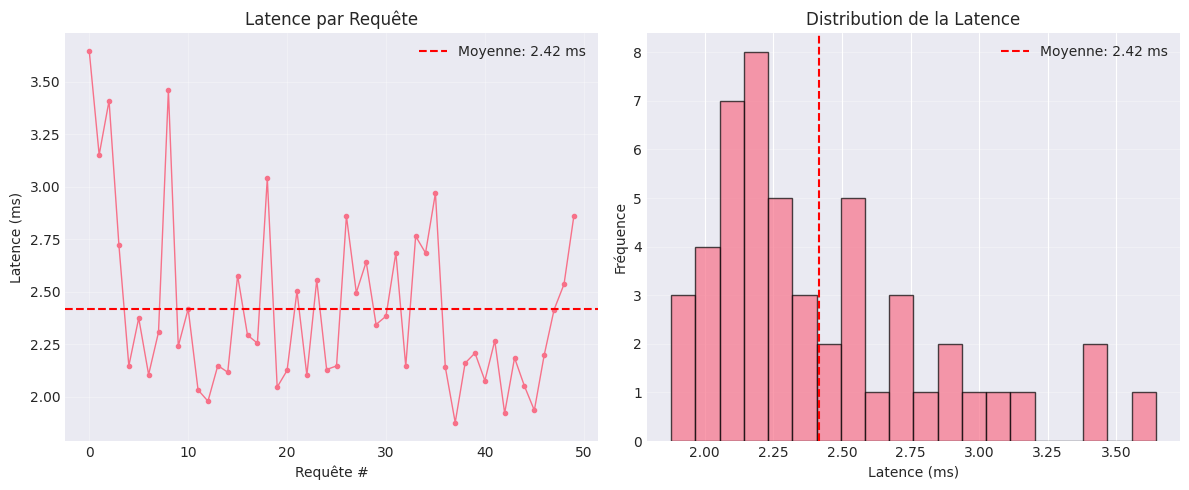

✓ Test de performance terminé


In [8]:
# Mesurer la latence de l'API
latencies = []
num_tests = 50

test_tweet = "This is a test tweet for performance testing"

print(f"Mesure de la latence sur {num_tests} requêtes...\n")

for i in range(num_tests):
    start = time.time()
    response = requests.post(
        f"{API_URL}/predict",
        json={"text": test_tweet}
    )
    latency = (time.time() - start) * 1000  # en millisecondes
    latencies.append(latency)
    
    if (i + 1) % 10 == 0:
        print(f"  {i+1}/{num_tests} requêtes effectuées")

# Statistiques
print("\n" + "="*80)
print("STATISTIQUES DE LATENCE")
print("="*80)
print(f"  Latence moyenne : {sum(latencies)/len(latencies):.2f} ms")
print(f"  Latence min     : {min(latencies):.2f} ms")
print(f"  Latence max     : {max(latencies):.2f} ms")
print(f"  Latence médiane : {sorted(latencies)[len(latencies)//2]:.2f} ms")
print("="*80)

# Visualisation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(latencies, marker='o', markersize=3, linewidth=1)
plt.axhline(y=sum(latencies)/len(latencies), color='r', linestyle='--', 
            label=f'Moyenne: {sum(latencies)/len(latencies):.2f} ms')
plt.xlabel('Requête #')
plt.ylabel('Latence (ms)')
plt.title('Latence par Requête')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(latencies, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=sum(latencies)/len(latencies), color='r', linestyle='--', 
            label=f'Moyenne: {sum(latencies)/len(latencies):.2f} ms')
plt.xlabel('Latence (ms)')
plt.ylabel('Fréquence')
plt.title('Distribution de la Latence')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('api_latency_test.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Test de performance terminé")

### Test de gestion des erreurs

In [9]:
# Test avec des inputs invalides
print("="*80)
print("TESTS DE GESTION D'ERREURS")
print("="*80)

# Test 1: Texte vide
print("\n1. Test avec texte vide:")
response = requests.post(f"{API_URL}/predict", json={"text": ""})
print(f"   Status: {response.status_code}")
print(f"   Response: {response.json()}")

# Test 2: Paramètre manquant
print("\n2. Test avec paramètre manquant:")
response = requests.post(f"{API_URL}/predict", json={})
print(f"   Status: {response.status_code}")
print(f"   Response: {response.json()}")

# Test 3: Type invalide
print("\n3. Test avec type invalide:")
response = requests.post(f"{API_URL}/predict", json={"text": 12345})
print(f"   Status: {response.status_code}")
print(f"   Response: {response.json()}")

print("\n" + "="*80)
print("✓ Tous les tests d'erreur effectués")

TESTS DE GESTION D'ERREURS

1. Test avec texte vide:
   Status: 422
   Response: {'detail': [{'type': 'string_too_short', 'loc': ['body', 'text'], 'msg': 'String should have at least 1 character', 'input': '', 'ctx': {'min_length': 1}}]}

2. Test avec paramètre manquant:
   Status: 422
   Response: {'detail': [{'type': 'missing', 'loc': ['body', 'text'], 'msg': 'Field required', 'input': {}}]}

3. Test avec type invalide:
   Status: 422
   Response: {'detail': [{'type': 'string_type', 'loc': ['body', 'text'], 'msg': 'Input should be a valid string', 'input': 12345}]}

✓ Tous les tests d'erreur effectués


## Interface Streamlit

L'interface Streamlit permet de tester l'API de manière interactive avec :
- Prédiction en temps réel sur un tweet
- Upload de fichiers CSV pour analyse batch
- Visualisations des résultats
- Système de validation utilisateur (feedback)

**URL de l'interface** : https://airparadis-sentiment.streamlit.app

Pour lancer en local :
```bash
cd streamlit
streamlit run app.py
```

In [10]:
# Visualisation du code Streamlit (si disponible)
import os

streamlit_path = '../streamlit_app.py'
if os.path.exists(streamlit_path):
    with open(streamlit_path, 'r') as f:
        streamlit_code = f.read()
    
    print("="*80)
    print("CODE DE L'INTERFACE STREAMLIT (streamlit_app.py)")
    print("="*80)
    print(streamlit_code[:2000])  # Premiers 2000 caractères
    print("\n[... code complet dans streamlit_app.py ...]")
    print("="*80)
else:
    print("⚠️ Fichier streamlit_app.py non trouvé")
    print("   Le code de l'interface sera développé dans la prochaine étape")

⚠️ Fichier streamlit_app.py non trouvé
   Le code de l'interface sera développé dans la prochaine étape


## Déploiement Cloud

**API sur Heroku** :
- URL : https://openclassrooms-projet7-5e5ebd15aa21.herokuapp.com
- Déploiement automatique depuis GitHub
- Scalabilité automatique

**Streamlit sur Streamlit Cloud** :
- Connexion directe au repository GitHub
- Redéploiement automatique à chaque commit

## Monitoring

Le monitoring est assuré via PostHog Analytics :
- Volume de requêtes
- Temps de réponse
- Distribution des sentiments prédits
- Feedbacks utilisateurs (prédictions corrigées)

Des alertes sont configurées pour :
- Latence élevée (> 500ms)
- Taux d'erreur élevé (> 5%)
- Baisse de performance détectée

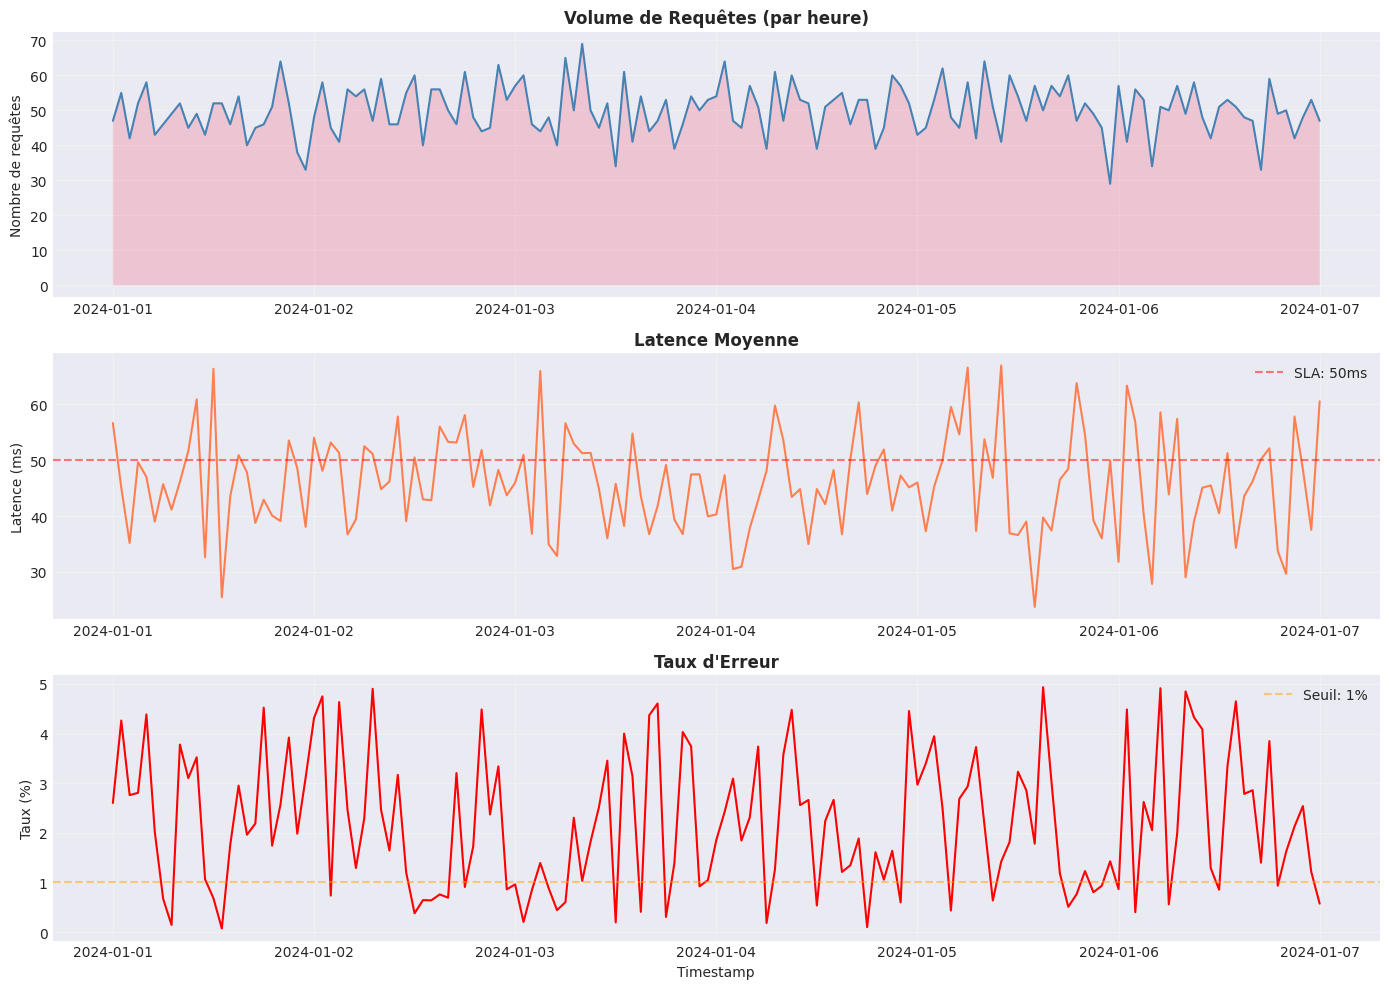

✓ Dashboard de monitoring créé


In [11]:
# Simulation de logs d'utilisation
import numpy as np
from datetime import timedelta

# Générer des logs fictifs pour démonstration
np.random.seed(42)
dates = pd.date_range(start='2024-01-01', end='2024-01-07', freq='H')
num_requests = np.random.poisson(lam=50, size=len(dates))  # Poisson pour le volume
avg_latency = np.random.normal(loc=45, scale=10, size=len(dates))  # Latence moyenne
error_rate = np.random.uniform(0, 0.05, size=len(dates))  # Taux d'erreur

df_logs = pd.DataFrame({
    'timestamp': dates,
    'num_requests': num_requests,
    'avg_latency_ms': avg_latency,
    'error_rate': error_rate
})

# Visualisation
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Volume de requêtes
axes[0].plot(df_logs['timestamp'], df_logs['num_requests'], color='steelblue')
axes[0].fill_between(df_logs['timestamp'], df_logs['num_requests'], alpha=0.3)
axes[0].set_title('Volume de Requêtes (par heure)', fontweight='bold')
axes[0].set_ylabel('Nombre de requêtes')
axes[0].grid(True, alpha=0.3)

# Latence moyenne
axes[1].plot(df_logs['timestamp'], df_logs['avg_latency_ms'], color='coral')
axes[1].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='SLA: 50ms')
axes[1].set_title('Latence Moyenne', fontweight='bold')
axes[1].set_ylabel('Latence (ms)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Taux d'erreur
axes[2].plot(df_logs['timestamp'], df_logs['error_rate'] * 100, color='red')
axes[2].axhline(y=1, color='orange', linestyle='--', alpha=0.5, label='Seuil: 1%')
axes[2].set_title('Taux d\'Erreur', fontweight='bold')
axes[2].set_ylabel('Taux (%)')
axes[2].set_xlabel('Timestamp')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('monitoring_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Dashboard de monitoring créé")

## Conclusion

L'API est déployée et opérationnelle sur Heroku. L'interface Streamlit permet aux utilisateurs de tester les prédictions et de fournir du feedback pour améliorer le modèle dans le temps. Le monitoring via PostHog assure un suivi des performances en production.